# I. Imports

In [ ]:
# import required libraries and packages
import pickle
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import SVG
import matplotlib.pyplot as plt
%matplotlib inline
import os, re, sys, random, shutil, cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, ZeroPadding2D, Dropout

# II. InceptionResNetV2-UNet 
[Here](https://colab.research.google.com/github/ricardocarvalhods/dpcgan/blob/master/DP_CGAN_MNIST.ipynb#scrollTo=hOBQELw7mo9Z&line=21&uniqifier=1) is the recognition credit for the model and customization functions. 


In [ ]:
# customize model
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_inception_resnetv2_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained InceptionResNetV2 Model """
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = encoder.get_layer("input_1").output           ## (512 x 512)

    s2 = encoder.get_layer("activation").output        ## (255 x 255)
    s2 = ZeroPadding2D(( (1, 0), (1, 0) ))(s2)         ## (256 x 256)

    s3 = encoder.get_layer("activation_3").output      ## (126 x 126)
    s3 = ZeroPadding2D((1, 1))(s3)                     ## (128 x 128)

    s4 = encoder.get_layer("activation_74").output      ## (61 x 61)
    s4 = ZeroPadding2D(( (2, 1),(2, 1) ))(s4)           ## (64 x 64)

    """ Bridge """
    b1 = encoder.get_layer("activation_161").output     ## (30 x 30)
    b1 = ZeroPadding2D((1, 1))(b1)                      ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
    
    """ Output """
    dropout = Dropout(0.3)(d4)
    outputs = Conv2D(6, 1, padding="same", activation="softmax")(dropout)

    model = Model(inputs, outputs, name="InceptionResNetV2-UNet")
    return model


In [ ]:
K.clear_session()

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

model = build_inception_resnetv2_unet(input_shape = (512, 512, 3))
model.compile(optimizer=Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=[dice_coef, "accuracy"])
model.summary()

219055592/219055592 [==============================] - 1s 0us/step


Model: "InceptionResNetV2-UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 255, 255, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 255, 255, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                            

In [ ]:
model.load_weights("/content/drive/MyDrive/ds549/weights/InceptionResNetV2-UNet.h5")

# III. Inference

The prediction pipeline is as follows: 
1. resize imgs 
2. run model inference 
3. extract predicted classes for each pixel 
4. calculate proportion of pixels that belong to each class 5. create df
6. convert model predicts to rgb images and visualize them for sanity check



In [ ]:
image_path ='/content/drive/MyDrive/ds549/data/500m/'
image_list = os.listdir(image_path)
image_list = [image_path + i for i in image_list] # create a list of path names for images
name_list = [i.split('/')[-1] for i in image_list] # create a list of school names for images

In [ ]:
def resize_image(img, width=512, height=512):
    """
    Takes as input an image (width, height, rgb) and
    resize it to a 4D array (1, width=512, height=512, rgb)
    """
    dim = (width, height)
    resize_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    resize_img = np.expand_dims(resize_img, axis=0)
    return resize_img

In [ ]:
def detect_classes(cls_matrix):
  cls_detected = [0] * 6
  # print(len(cls_detected))
  for cls in np.unique(cls_matrix):
    cls_detected[cls] += 1
  return cls_detected


In [ ]:
def calc_coverage(cls_matrix):
  cls_prop = [0] * 6
  
  for cls in np.unique(cls_matrix):
     cls_prop[cls] = (cls_matrix == cls).sum() / (cls_matrix.shape[0] * cls_matrix.shape[1])
      
  return cls_prop

In [ ]:
def create_df(data, name_list):
    df = pd.DataFrame(data, columns = ['building', 'land', 'road', 'vegetation', 'water', 'unlabelled'])
    df.insert(0, "name", name_list)
    return df

In [ ]:
id2code = {0: [60, 16, 152],
           1: [132, 41, 246],
           2: [110, 193, 228],
           3: [254, 221, 58],
           4: [226, 169, 41],
           5: [155, 155, 155]}

def pred_to_rgb(pred_probs, id2code):
    """
     Takes as input of 2D matrix (width x height) where 
    elements represent predicted class of each pixel and 
    outputs 3D matrix (width x height x rgb)
    """
    # initialize rgb image
    cls_matrix = np.argmax(pred_probs, axis=-1)
    rgb_encode_image = np.zeros((cls_matrix.shape[0], cls_matrix.shape[1], 3))

    for row in range(cls_matrix.shape[0]):
        for col in range(cls_matrix.shape[1]):
          for cls, rgb in id2code.items():
            # print(cls, rgb)
            if cls_matrix[row][col] == cls:
              #print(mask[row][col] == cls)
              rgb_encode_image[row][col] = id2code[cls]
              
    return np.uint8(rgb_encode_image)

           
# rgb_image = pred_to_rgb(pred_probs, id2code)
# rgb_image.shape

In [ ]:
rgb_imgs = []
cls_props = []

for index in range(len(image_list)):
    print("extracting info from image {}...".format(index))
    img = cv2.imread(image_list[index])
    resize_img = resize_image(img, width=512, height=512)

    # make prediction and remove 1st dim
    pred_probs = np.squeeze(model.predict(resize_img))
    
    # calculate predicted class based on position of greatest prob
    cls_matrix = np.argmax(pred_probs, axis=-1)
    cls_props.append(calc_coverage(cls_matrix))

    rgb_img = pred_to_rgb(pred_probs, id2code)
    rgb_imgs.append(rgb_img)

extracting info from image 0...
1/1 [==============================] - 6s 6s/step
extracting info from image 1...
1/1 [==============================] - 5s 5s/step
extracting info from image 2...
1/1 [==============================] - 5s 5s/step
extracting info from image 3...
1/1 [==============================] - 7s 7s/step
extracting info from image 4...
1/1 [==============================] - 5s 5s/step
extracting info from image 5...
1/1 [==============================] - 7s 7s/step
extracting info from image 6...
1/1 [==============================] - 6s 6s/step
extracting info from image 7...
1/1 [==============================] - 5s 5s/step
extracting info from image 8...
1/1 [==============================] - 5s 5s/step
extracting info from image 9...
1/1 [==============================] - 7s 7s/step
extracting info from image 10...
1/1 [==============================] - 7s 7s/step
extracting info from image 11...
1/1 [==============================] - 5s 5s/step
extracting inf

TypeError: ignored

In [ ]:
# sanity check
df.head()

,name,building,land,road,vegetation,water,unlabelled
0,Dorchester_Academy___1.png,0.000202,0.023392,0.000099,0.000023,0.976284,0.0
1,"Adams,_Samuel_Elementary_.png",0.000271,0.031265,0.000027,0.000008,0.968430,0.0
2,Young_Achievers_Science__.png,0.000725,0.018154,0.000706,0.000423,0.979992,0.0
3,"Alighieri,_Dante_Montesso.png",0.000240,0.028248,0.000725,0.000042,0.970745,0.0
4,Another_Course_to_College.png,0.000519,0.021538,0.000443,0.000294,0.977207,0.0


In [ ]:
# save df to csv
final_dir = 'drive/MyDrive/ds549/'
df.to_csv(os.path.join(final_dir, 'eco_services.csv'))

# IV. Sanity Check

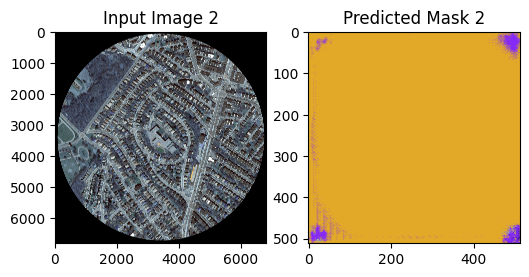

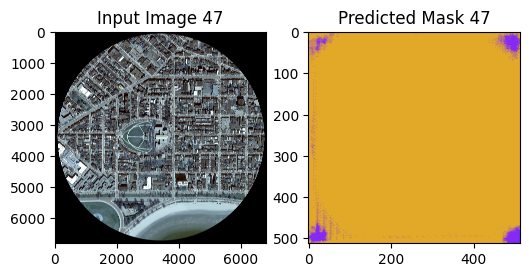

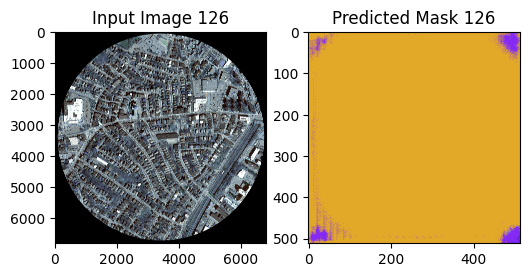

In [ ]:
# sanity check for predicted masks
for _ in range(3):
  fig = plt.figure(figsize=(6,6))

  sample = random.randint(0,133)

  img = cv2.imread(image_list[sample])
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(img)
  ax1.set_title('Input Image {}'.format(sample))
  ax1.grid(False)

  ax2 = fig.add_subplot(1, 2, 2)
  ax2.imshow(rgb_imgs[sample])
  ax2.set_title('Predicted Mask {}'.format(sample))
  ax2.grid(False)